In [1]:
import numpy as np
import h5py
import keras
from keras.models import Model, clone_model
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import sys
import warnings
from tqdm import tqdm
import os

In [23]:
def data(filepath):
    with h5py.File(filepath, 'r') as data:
        x_data = np.array(data['data']).transpose((0, 2, 3, 1))
        y_data = np.array(data['label'])

    return x_data, y_data

In [3]:
clean_data_x, clean_data_y = data(os.path.join(os.getcwd(), "data", "cl", "valid.h5"))
badnet_data_x, badnet_data_y = data(os.path.join(os.getcwd(), "data", "bd", "bd_valid.h5"))
badnet_model = keras.models.load_model(os.path.join(os.getcwd(), "models", "bd_net.h5"))

In [4]:
predictions = badnet_model.predict(clean_data_x)
clean_data_label_pred = np.argmax(predictions, axis=1)

# Calculating clean data accuracy
correct_predictions = np.sum(clean_data_label_pred == clean_data_y)
total_samples = len(clean_data_y)
clean_accuracy = (correct_predictions / total_samples)
print("clean data accuracy:", clean_accuracy)

361/361 [==============================] - 6s 14ms/step
clean data accuracy: 0.9864899974019226


In [5]:
badnet_predictions = badnet_model.predict(badnet_data_x)
badnet_data_label_pred = np.argmax(badnet_predictions, axis=1)

# Calculating badnet attack success rate
successful_attack = np.sum(badnet_data_label_pred == badnet_data_y)
total_samples = len(badnet_data_y)
attack_success_rate = (successful_attack / total_samples)
print("Attack success rate:", attack_success_rate)

361/361 [==============================] - 6s 16ms/step
Attack success rate: 1.0


In [6]:
# Function to calculate accuracy
def calculate_accuracy(model):
    predictions = model.predict(clean_data_x)
    correct_predictions = np.sum(np.argmax(predictions, axis=1) == clean_data_y)
    accuracy = correct_predictions / len(clean_data_y)
    return accuracy

# Function to create a copy of the model
def copy_model(model):
    return clone_model(model)

In [7]:
def evaluate_attack_success_rate(model):
    predictions = model.predict(badnet_data_x)
    correct_predictions = np.sum(np.argmax(predictions, axis=1) == badnet_data_y)
    accuracy = correct_predictions / len(badnet_data_y)
    return accuracy

In [8]:
md = keras.models.load_model(os.path.join(os.getcwd(), "models", "bd_net.h5"))
pruned_channel_index = []
md_saved = [False, False, False]

In [9]:
clean_data_accuracy = calculate_accuracy(md)
print(clean_data_accuracy)

361/361 [==============================] - 5s 13ms/step
0.9864899974019226


In [10]:
# Function to get the intermediate output of a layer
def get_intermediate_output(model, layer_name, x=clean_data_x):
    intermediate_layer = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer.predict(x)
    return intermediate_output

In [11]:
# Function to calculate the average activation values for each channel
def calculate_channel_average_activation(intermediate_output):
    channel_average_activation = np.mean(intermediate_output, axis=(0, 1, 2))
    return channel_average_activation

In [12]:
# Function to prune a specific channel in a layer
def prune_channel(model, channel_index):
    layer = model.get_layer(index=5)
    weights = layer.get_weights()
    weights[0][:, :, :, channel_index] = 0
    weights[1][channel_index] = 0
    layer.set_weights(weights)

In [14]:
# Function to prune the channels of a layer in descending order of activation values
def prune_channels(model, layer_name, x, y, clean_data_accuracy):
    pruned_model = copy_model(model)
    pruned_model.set_weights(model.get_weights())

    intermediate_output = get_intermediate_output(model, layer_name)
    sorted_channels = np.argsort(calculate_channel_average_activation(intermediate_output))
    
    pruned_clean_accuracy_list = []
    attack_success_rate_list = []
    for channel_index in tqdm(sorted_channels):
        prune_channel(pruned_model, channel_index)

        pruned_clean_accuracy = calculate_accuracy(pruned_model)
        pruned_clean_accuracy_list.append(pruned_clean_accuracy)
        accuracy_drop = clean_data_accuracy - pruned_clean_accuracy

        for idx, threshold in enumerate([0.02, 0.04, 0.10]):
            if accuracy_drop >= threshold and not md_saved[idx]:
                pruned_model.save(f"model_{int(threshold * 100)}_percent_drop.h5")
                md_saved[idx] = True
                print(f"Model saved with {int(threshold * 100)}% accuracy drop.")
        
        attack_success_rate_list.append(evaluate_attack_success_rate(pruned_model))

    for channel_index, pruned_clean_accuracy, attack_success_rate in zip(sorted_channels, pruned_clean_accuracy_list, attack_success_rate_list):
        print(f"Pruned Channel Index: {channel_index}, Clean Accuracy: {pruned_clean_accuracy}, Attack Success Rate: {attack_success_rate}")

    return pruned_model, pruned_clean_accuracy_list, attack_success_rate_list

In [15]:
md = keras.models.load_model(os.path.join(os.getcwd(), "models", "bd_net.h5"))
threshold_list = [0.02, 0.04, 0.10]
pruned_model, clean_accuracy_list, attack_success_rate_list = prune_channels(md, 'pool_3', clean_data_x, clean_data_y, clean_data_accuracy)

361/361 [==============================] - 5s 14ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 5s 14ms/step


  2%|▏         | 1/60 [00:18<17:44, 18.04s/it]

361/361 [==============================] - 7s 18ms/step


  3%|▎         | 2/60 [00:31<15:00, 15.53s/it]

361/361 [==============================] - 5s 13ms/step


  5%|▌         | 3/60 [00:52<17:10, 18.08s/it]

361/361 [==============================] - 5s 13ms/step


  7%|▋         | 4/60 [01:03<14:15, 15.27s/it]

361/361 [==============================] - 6s 16ms/step


  8%|▊         | 5/60 [01:15<12:56, 14.12s/it]

361/361 [==============================] - 5s 15ms/step


 10%|█         | 6/60 [01:28<12:11, 13.55s/it]

361/361 [==============================] - 5s 15ms/step


 12%|█▏        | 7/60 [01:44<12:33, 14.22s/it]

361/361 [==============================] - 5s 14ms/step


 13%|█▎        | 8/60 [01:56<11:52, 13.69s/it]

361/361 [==============================] - 17s 48ms/step


 15%|█▌        | 9/60 [02:24<15:19, 18.03s/it]

361/361 [==============================] - 5s 13ms/step


 17%|█▋        | 10/60 [02:36<13:39, 16.38s/it]

361/361 [==============================] - 24s 66ms/step


 18%|█▊        | 11/60 [03:23<20:51, 25.55s/it]

361/361 [==============================] - 4s 12ms/step


 20%|██        | 12/60 [03:35<17:06, 21.39s/it]

361/361 [==============================] - 9s 24ms/step


 22%|██▏       | 13/60 [03:52<15:51, 20.25s/it]

361/361 [==============================] - 6s 16ms/step


 23%|██▎       | 14/60 [04:11<15:06, 19.71s/it]

361/361 [==============================] - 5s 15ms/step


 25%|██▌       | 15/60 [04:24<13:15, 17.68s/it]

361/361 [==============================] - 5s 15ms/step


 27%|██▋       | 16/60 [04:35<11:38, 15.88s/it]

361/361 [==============================] - 5s 14ms/step


 28%|██▊       | 17/60 [04:47<10:29, 14.64s/it]

361/361 [==============================] - 5s 14ms/step


 30%|███       | 18/60 [04:59<09:40, 13.82s/it]

361/361 [==============================] - 6s 16ms/step


 32%|███▏      | 19/60 [05:12<09:17, 13.59s/it]

361/361 [==============================] - 6s 16ms/step


 33%|███▎      | 20/60 [05:25<08:52, 13.32s/it]

361/361 [==============================] - 7s 18ms/step


 35%|███▌      | 21/60 [05:40<08:58, 13.81s/it]

361/361 [==============================] - 7s 18ms/step


 37%|███▋      | 22/60 [05:54<08:47, 13.88s/it]

361/361 [==============================] - 6s 17ms/step


 38%|███▊      | 23/60 [06:08<08:39, 14.05s/it]

361/361 [==============================] - 6s 16ms/step


 40%|████      | 24/60 [06:21<08:15, 13.76s/it]

361/361 [==============================] - 5s 15ms/step


 42%|████▏     | 25/60 [06:34<07:46, 13.33s/it]

361/361 [==============================] - 6s 17ms/step


 43%|████▎     | 26/60 [06:47<07:36, 13.43s/it]

361/361 [==============================] - 5s 15ms/step


 45%|████▌     | 27/60 [07:00<07:12, 13.11s/it]

361/361 [==============================] - 5s 15ms/step


 47%|████▋     | 28/60 [07:12<06:47, 12.75s/it]

361/361 [==============================] - 6s 17ms/step


 48%|████▊     | 29/60 [07:25<06:42, 12.99s/it]

361/361 [==============================] - 6s 16ms/step


 50%|█████     | 30/60 [07:38<06:30, 13.03s/it]

361/361 [==============================] - 6s 15ms/step


 52%|█████▏    | 31/60 [07:51<06:13, 12.88s/it]

361/361 [==============================] - 5s 14ms/step


 53%|█████▎    | 32/60 [08:02<05:46, 12.39s/it]

361/361 [==============================] - 5s 15ms/step


 55%|█████▌    | 33/60 [08:14<05:28, 12.16s/it]

361/361 [==============================] - 7s 21ms/step


 57%|█████▋    | 34/60 [08:29<05:40, 13.08s/it]

361/361 [==============================] - 11s 31ms/step


 58%|█████▊    | 35/60 [08:57<07:22, 17.70s/it]

361/361 [==============================] - 12s 34ms/step


 60%|██████    | 36/60 [09:24<08:08, 20.36s/it]

361/361 [==============================] - 8s 21ms/step


 62%|██████▏   | 37/60 [09:50<08:31, 22.23s/it]

361/361 [==============================] - 5s 14ms/step


 63%|██████▎   | 38/60 [10:01<06:55, 18.86s/it]

361/361 [==============================] - 9s 25ms/step


 65%|██████▌   | 39/60 [10:21<06:38, 18.99s/it]

361/361 [==============================] - 6s 18ms/step


 67%|██████▋   | 40/60 [10:40<06:19, 18.95s/it]

361/361 [==============================] - 6s 17ms/step


 68%|██████▊   | 41/60 [10:55<05:40, 17.92s/it]

361/361 [==============================] - 6s 16ms/step


 70%|███████   | 42/60 [11:08<04:57, 16.52s/it]

361/361 [==============================] - 6s 17ms/step


 72%|███████▏  | 43/60 [11:22<04:24, 15.57s/it]

361/361 [==============================] - 6s 16ms/step


 73%|███████▎  | 44/60 [11:35<03:56, 14.76s/it]

361/361 [==============================] - 6s 17ms/step


c:\users\raj ghodasara\documents\venvs\mlcslab4\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved with 2% accuracy drop.
361/361 [==============================] - 7s 19ms/step


 75%|███████▌  | 45/60 [11:50<03:44, 14.99s/it]

361/361 [==============================] - 8s 22ms/step


 77%|███████▋  | 46/60 [12:07<03:39, 15.68s/it]

361/361 [==============================] - 7s 20ms/step


 78%|███████▊  | 47/60 [12:24<03:26, 15.88s/it]

361/361 [==============================] - 7s 19ms/step
Model saved with 4% accuracy drop.
361/361 [==============================] - 8s 22ms/step


 80%|████████  | 48/60 [12:40<03:13, 16.10s/it]

361/361 [==============================] - 6s 17ms/step


 82%|████████▏ | 49/60 [12:55<02:51, 15.62s/it]

361/361 [==============================] - 6s 17ms/step


 83%|████████▎ | 50/60 [13:08<02:29, 14.97s/it]

361/361 [==============================] - 7s 20ms/step


 85%|████████▌ | 51/60 [13:26<02:23, 15.91s/it]

361/361 [==============================] - 7s 18ms/step
Model saved with 10% accuracy drop.
361/361 [==============================] - 7s 19ms/step


 87%|████████▋ | 52/60 [13:42<02:06, 15.83s/it]

361/361 [==============================] - 7s 19ms/step


 88%|████████▊ | 53/60 [13:57<01:49, 15.61s/it]

361/361 [==============================] - 6s 17ms/step


 90%|█████████ | 54/60 [14:15<01:38, 16.34s/it]

361/361 [==============================] - 7s 19ms/step


 92%|█████████▏| 55/60 [14:28<01:16, 15.40s/it]

361/361 [==============================] - 9s 25ms/step


 93%|█████████▎| 56/60 [14:49<01:07, 16.84s/it]

361/361 [==============================] - 7s 20ms/step


 95%|█████████▌| 57/60 [15:05<00:50, 16.80s/it]

361/361 [==============================] - 6s 17ms/step


 97%|█████████▋| 58/60 [15:20<00:32, 16.19s/it]

361/361 [==============================] - 7s 19ms/step


 98%|█████████▊| 59/60 [15:35<00:15, 15.69s/it]

361/361 [==============================] - 6s 18ms/step


100%|██████████| 60/60 [15:50<00:00, 15.84s/it]

Pruned Channel Index: 0, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 26, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 27, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 30, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 31, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 33, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 34, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 36, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 37, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 38, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 25, Clean Accuracy: 0.9864899974019226, Attack Success Rate: 1.0
Pruned Channel Index: 39, Clean Accuracy: 0.

In [16]:
# Define the fraction of channels pruned
fraction_pruned = np.arange(0, 60) / 60

## Table of accuracy on clean test data and the attack success rate (on backdoored test data) as a function of the fraction of channels pruned (X)

+-------------------------------+----------------------------+-----------------------------------------------+
| Fraction of Channels Pruned   |   Clean Test Data Accuracy |   Attack Success Rate on backdoored test data |
+===============================+============================+===============================================+
| 1/60                          |                0.98649     |                                    1          |
+-------------------------------+----------------------------+-----------------------------------------------+
| 2/60                          |                0.98649     |                                    1          |
+-------------------------------+----------------------------+-----------------------------------------------+
| 3/60                          |                0.98649     |                                    1          |
+-------------------------------+----------------------------+-----------------------------------------------+
|

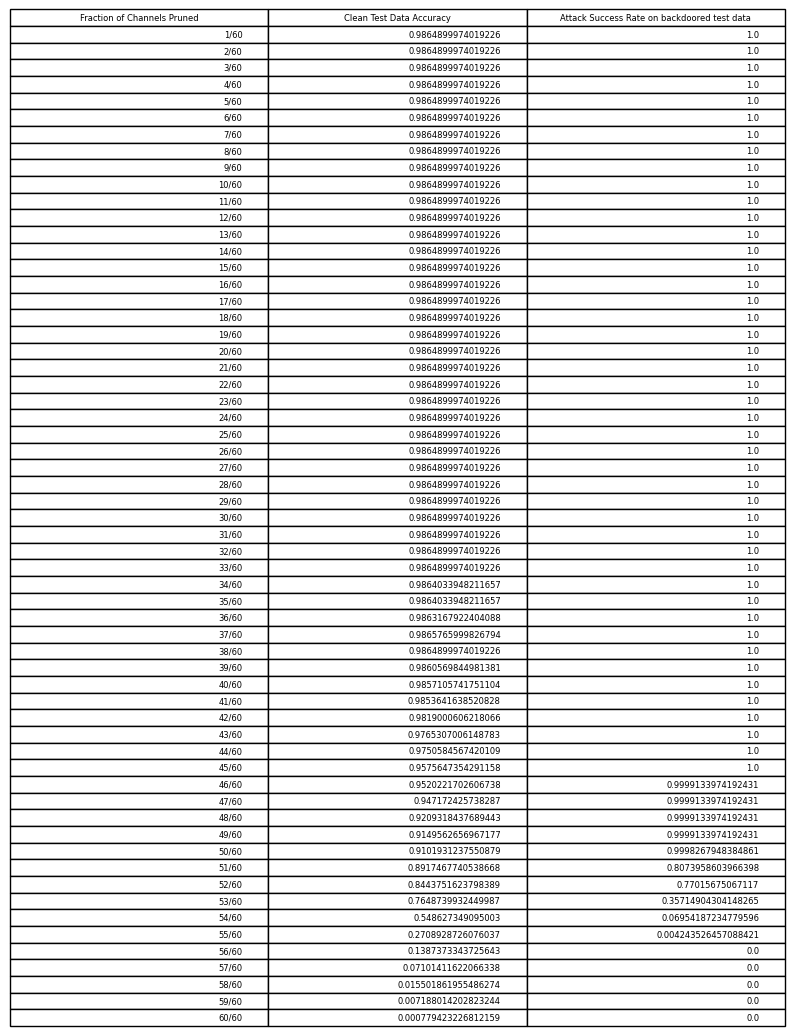

In [47]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Create a list of tuples containing the percent of channels pruned, clean accuracy, and attack success rate
data_table = []
for i in range(len(fraction_pruned)):
    data_table.append(("{}/60".format(i+1), clean_accuracy_list[i], attack_success_rate_list[i]))

# Print the table
table = tabulate(data_table, headers=['Fraction of Channels Pruned', 'Clean Test Data Accuracy', 'Attack Success Rate on backdoored test data'], tablefmt='grid')
print(table)

# # Save the table as a JPEG image
# plt.figure(figsize=(10, 6))
# plt.axis('off')
# plt.table(cellText=data_table, colLabels=['Fraction of Channels Pruned', 'Clean Test Data Accuracy', 'Attack Success Rate on backdoored test data'], loc='center')
# plt.savefig('table.jpg', bbox_inches='tight', pad_inches=0.5)


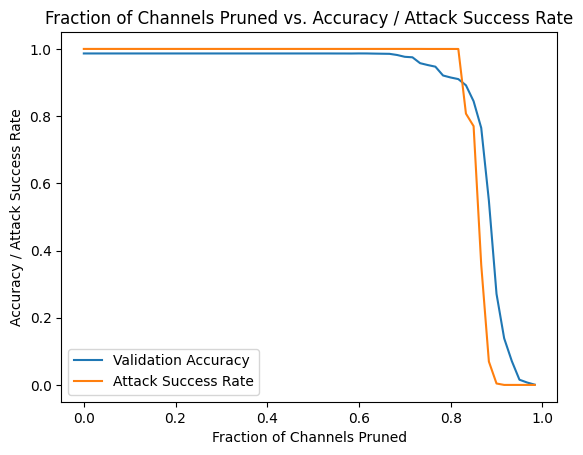

In [48]:
# Plot the validation accuracy
plt.plot(fraction_pruned, clean_accuracy_list, label='Validation Accuracy')

# Plot the attack success rate
plt.plot(fraction_pruned, attack_success_rate_list, label='Attack Success Rate')

# Add labels and title to the plot
plt.xlabel('Fraction of Channels Pruned')
plt.ylabel('Accuracy / Attack Success Rate')
plt.title('Fraction of Channels Pruned vs. Accuracy / Attack Success Rate')

# Add legend to the plot
plt.legend()

# Save the plot as an image
# plt.savefig('plot.png')

# Show the plot
plt.show()


In [20]:
class G(keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self, data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        pred = np.where(y == y_prime, y, 1283)
        return pred


In [24]:
clean_test_data_x, clean_test_data_y = data(os.path.join(os.getcwd(), "data", "cl", "test.h5"))
badnet_test_data_x, badnet_test_data_y = data(os.path.join(os.getcwd(), "data", "bd", "bd_test.h5"))

In [25]:
# load the models
model_2_percent = keras.models.load_model(os.path.join(os.getcwd(), "model_2_percent_drop.h5"))
model_4_percent = keras.models.load_model(os.path.join(os.getcwd(), "model_4_percent_drop.h5"))
model_10_percent = keras.models.load_model(os.path.join(os.getcwd(), "model_10_percent_drop.h5"))

In [26]:
def calculate_test_accuracy(model):
    predictions = model.predict(clean_test_data_x)
    correct_predictions = np.sum(np.argmax(predictions, axis=1) == clean_test_data_y)
    accuracy = correct_predictions / len(clean_test_data_y)
    return accuracy

def evaluate_test_attack_success_rate(model):
    predictions = model.predict(badnet_test_data_x)
    correct_predictions = np.sum(np.argmax(predictions, axis=1) == badnet_test_data_y)
    accuracy = correct_predictions / len(badnet_test_data_y)
    return accuracy

# Repaired Models

In [27]:
# Calculate test accuracies
test_accuracy_2_percent = calculate_test_accuracy(model_2_percent)
test_accuracy_4_percent = calculate_test_accuracy(model_4_percent)
test_accuracy_10_percent = calculate_test_accuracy(model_10_percent)

# Print test accuracies
print("Test Accuracy - 2% Model:", test_accuracy_2_percent)
print("Test Accuracy - 4% Model:", test_accuracy_4_percent)
print("Test Accuracy - 10% Model:", test_accuracy_10_percent)

# Test accuracies
test_accuracies = [test_accuracy_2_percent, test_accuracy_4_percent, test_accuracy_10_percent]



401/401 [==============================] - 7s 17ms/step
Test Accuracy - 2% Model: 0.9590023382696804
Test Accuracy - 4% Model: 0.9229150428682775
Test Accuracy - 10% Model: 0.8454403741231489


In [28]:
# Calculate attack success rates
attack_success_rate_2_percent = evaluate_test_attack_success_rate(model_2_percent)
attack_success_rate_4_percent = evaluate_test_attack_success_rate(model_4_percent)
attack_success_rate_10_percent = evaluate_test_attack_success_rate(model_10_percent)

# Print attack success rates
print("Attack Success Rate - 2% Model:", attack_success_rate_2_percent)
print("Attack Success Rate - 4% Model:", attack_success_rate_4_percent)
print("Attack Success Rate - 10% Model:", attack_success_rate_10_percent)

# Attack success rates
attack_success_rates = [attack_success_rate_2_percent, attack_success_rate_4_percent, attack_success_rate_10_percent]


401/401 [==============================] - 7s 17ms/step
Attack Success Rate - 2% Model: 1.0
Attack Success Rate - 4% Model: 0.9998441153546376
Attack Success Rate - 10% Model: 0.7720966484801247


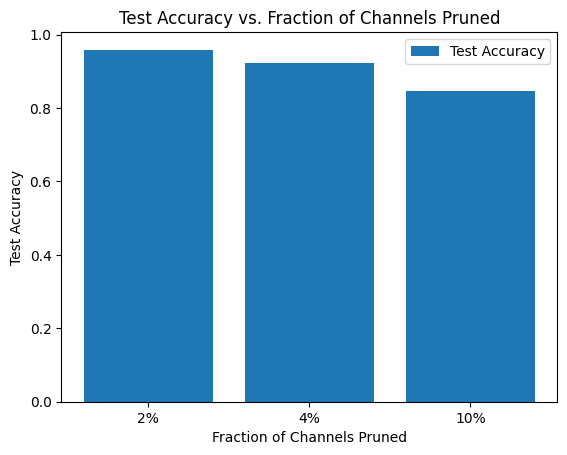

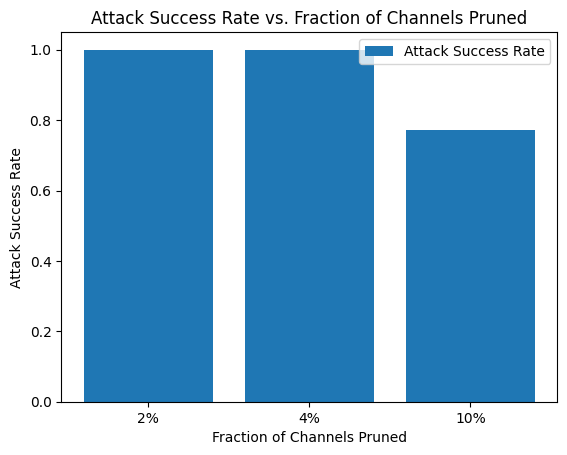

In [29]:
# Labels for x-axis
labels = ['2%', '4%', '10%']

# Plotting the test accuracies
plt.bar(labels, test_accuracies, label='Test Accuracy')

# Adding labels and title to the plot
plt.xlabel('Fraction of Channels Pruned')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Fraction of Channels Pruned')

# Adding legend to the plot
plt.legend()

# Displaying the plot
plt.show()

# Plotting the attack success rates
plt.bar(labels, attack_success_rates, label='Attack Success Rate')

# Adding labels and title to the plot
plt.xlabel('Fraction of Channels Pruned')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs. Fraction of Channels Pruned')

# Adding legend to the plot
plt.legend()

# Displaying the plot
plt.show()


# Goodnet models

In [30]:
goodnet_2_percent = G(badnet_model, model_2_percent)
goodnet_4_percent = G(badnet_model, model_4_percent)
goodnet_10_percent = G(badnet_model, model_10_percent)

In [31]:
def calculate_goodnet_test_accuracy(model):
    predictions = model.predict(clean_test_data_x)
    correct_predictions = np.sum(predictions == clean_test_data_y)
    accuracy = correct_predictions / len(clean_test_data_y)
    return accuracy

def evaluate_goodnet_test_attack_success_rate(model):
    predictions = model.predict(badnet_test_data_x)
    correct_predictions = np.sum(predictions == badnet_test_data_y)
    accuracy = correct_predictions / len(badnet_test_data_y)
    return accuracy

In [32]:
# Calculate test accuracies for goodnet models
goodnet_test_accuracy_2_percent = calculate_goodnet_test_accuracy(goodnet_2_percent)
goodnet_test_accuracy_4_percent = calculate_goodnet_test_accuracy(goodnet_4_percent)
goodnet_test_accuracy_10_percent = calculate_goodnet_test_accuracy(goodnet_10_percent)

# Print test accuracies for goodnet models
print("Test Accuracy - 2% Goodnet Model:", goodnet_test_accuracy_2_percent)
print("Test Accuracy - 4% Goodnet Model:", goodnet_test_accuracy_4_percent)
print("Test Accuracy - 10% Goodnet Model:", goodnet_test_accuracy_10_percent)

# Test accuracies for goodnet models
goodnet_test_accuracies = [goodnet_test_accuracy_2_percent, goodnet_test_accuracy_4_percent, goodnet_test_accuracy_10_percent]

Test Accuracy - 2% Goodnet Model: 0.9574434918160561
Test Accuracy - 4% Goodnet Model: 0.921278254091972
Test Accuracy - 10% Goodnet Model: 0.843335931410756


In [33]:
# Attack success rates for goodnet models
goodnet_attack_success_rate_2_percent = evaluate_goodnet_test_attack_success_rate(goodnet_2_percent)
goodnet_attack_success_rate_4_percent = evaluate_goodnet_test_attack_success_rate(goodnet_4_percent)
goodnet_attack_success_rate_10_percent = evaluate_goodnet_test_attack_success_rate(goodnet_10_percent)

# Print attack success rates for goodnet models
print("Attack Success Rate - 2% Goodnet Model:", goodnet_attack_success_rate_2_percent)
print("Attack Success Rate - 4% Goodnet Model:", goodnet_attack_success_rate_4_percent)
print("Attack Success Rate - 10% Goodnet Model:", goodnet_attack_success_rate_10_percent)

# Attack success rates for goodnet models
goodnet_attack_success_rates = [goodnet_attack_success_rate_2_percent, goodnet_attack_success_rate_4_percent, goodnet_attack_success_rate_10_percent]

Attack Success Rate - 2% Goodnet Model: 1.0
Attack Success Rate - 4% Goodnet Model: 0.9998441153546376
Attack Success Rate - 10% Goodnet Model: 0.7720966484801247


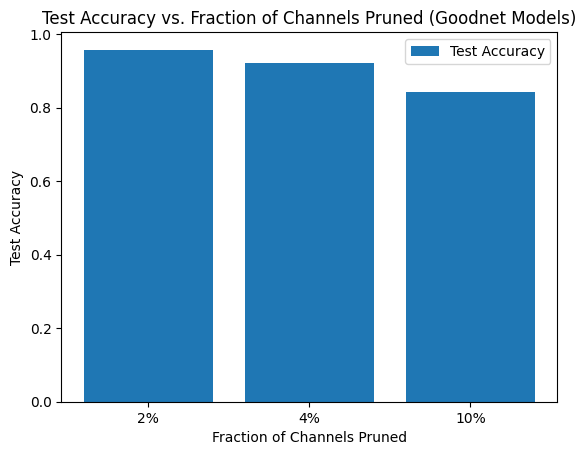

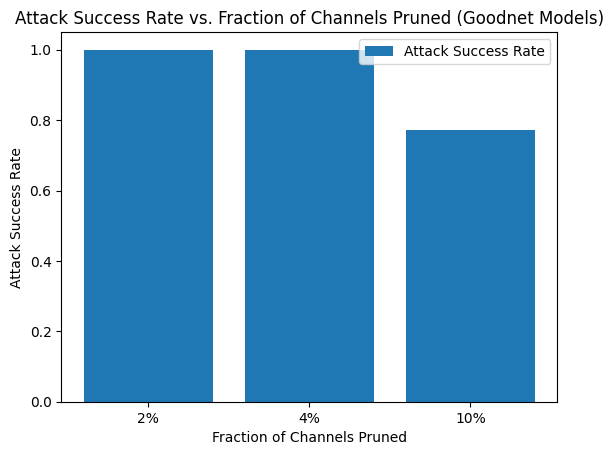

In [34]:
# Labels for x-axis
labels = ['2%', '4%', '10%']

# Plotting the test accuracies for goodnet models
plt.bar(labels, goodnet_test_accuracies, label='Test Accuracy')

# Adding labels and title to the plot
plt.xlabel('Fraction of Channels Pruned')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Fraction of Channels Pruned (Goodnet Models)')

# Adding legend to the plot
plt.legend()

# Displaying the plot
plt.show()

# Plotting the attack success rates for goodnet models
plt.bar(labels, goodnet_attack_success_rates, label='Attack Success Rate')

# Adding labels and title to the plot
plt.xlabel('Fraction of Channels Pruned')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs. Fraction of Channels Pruned (Goodnet Models)')

# Adding legend to the plot
plt.legend()

# Displaying the plot
plt.show()


In [37]:
from tabulate import tabulate

# Create a list of tuples containing the model percentage, clean data test accuracy, and attack success rate
regular_data_table = [
    ('2%', test_accuracy_2_percent, attack_success_rate_2_percent),
    ('4%', test_accuracy_4_percent, attack_success_rate_4_percent),
    ('10%', test_accuracy_10_percent, attack_success_rate_10_percent)
]

# Print the table
table = tabulate(data_table, headers=['Model Percentage', 'Clean Data Test Accuracy', 'Attack Success Rate'], tablefmt='grid')
print("Repaired model table")
print(table)


Repaired model table
+--------------------+----------------------------+-----------------------+
| Model Percentage   |   Clean Data Test Accuracy |   Attack Success Rate |
+====================+============================+=======================+
| 2%                 |                   0.959002 |              1        |
+--------------------+----------------------------+-----------------------+
| 4%                 |                   0.922915 |              0.999844 |
+--------------------+----------------------------+-----------------------+
| 10%                |                   0.84544  |              0.772097 |
+--------------------+----------------------------+-----------------------+


In [38]:
# Create a list of tuples containing the model percentage, clean data test accuracy, and attack success rate
goodnet_data_table = [
    ('2%', goodnet_test_accuracy_2_percent, goodnet_attack_success_rate_2_percent),
    ('4%', goodnet_test_accuracy_4_percent, goodnet_attack_success_rate_4_percent),
    ('10%', goodnet_test_accuracy_10_percent, goodnet_attack_success_rate_10_percent)
]

# Print the table
table = tabulate(goodnet_data_table, headers=['Model Percentage', 'Clean Data Test Accuracy', 'Attack Success Rate'], tablefmt='grid')
print("Goodnet model table")
print(table)


Goodnet model table
+--------------------+----------------------------+-----------------------+
| Model Percentage   |   Clean Data Test Accuracy |   Attack Success Rate |
+====================+============================+=======================+
| 2%                 |                   0.957443 |              1        |
+--------------------+----------------------------+-----------------------+
| 4%                 |                   0.921278 |              0.999844 |
+--------------------+----------------------------+-----------------------+
| 10%                |                   0.843336 |              0.772097 |
+--------------------+----------------------------+-----------------------+
